# Contact Tracing with Networks and Factors
- testing priority with networkx and covid-19 risk factors
- ian : assignment : AI4

## vulnerability
https://www.who.int/westernpacific/emergencies/covid-19/information/high-risk-groups
- age
    - 60+ age
- underlying health condition
    - lung
    - heart
    - diabetes 
    - immunocompromised

#### age factor
https://idpjournal.biomedcentral.com/articles/10.1186/s40249-020-00785-1
https://bmcpublichealth.biomedcentral.com/articles/10.1186/s12889-020-09826-8
- should we consider gender as external factors?

#### occupation factor?
https://www.michigan.gov/frontliners/0,9886,7-412-101948_100634_102083-532640--,00.html
- medical 
- non-medical frontliners
- others

#### symptoms
https://www.who.int/emergencies/diseases/novel-coronavirus-2019/question-and-answers-hub/q-a-detail/coronavirus-disease-covid-19#:~:text=symptoms

### Packages

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Data Preparation

### Factor Scoring
- custom made dataset for contact tracing with some factors
    - person
        - name
    - confirmed_covid
        - 10 points
        - to explode the value, and increase node importance and prioritize the contacts    
    - age
        - considered by WHO as high risk
        - age 60+
            - 5 points        
    - health_condition
        - considered by WHO as high risk
            - 5 points
                - lung
                - heart
                - diabetes
                - immunocompromised
    - symptoms
        - Current Metric
            - Choose highest point only    
            - if person has covid then disregard this score    
        - Most common symptoms: 3 points
            - fever
            - dry cough
            - tiredness
        - Less common symptoms: 1 points
            - aches and pains
            - sore throat
            - diarrhoea
            - conjunctivitis
            - headache
            - loss of taste or smell
            - a rash on skin, or discolouration of fingers or toes
        - Serious symptoms: 5 points
            - difficulty breathing or shortness of breath
            - chest pain or pressure
            - loss of speech or movement- immunocompromised           
    - contact
        - name of contact person
    - contact_type
        - layer of contact
        - 1st layer : Family / People living with
            - 3 points
        - 2nd layer : Colleagues / People you see daily
            - 2 points
        - 3rd layer : Others / People you see a few times or less
            - 1 points  
    - num of co-occupants
        - to be used for num_of_room metric
        - Npl value
    - num_of_room
        - current metric
            - 1 room is 3 points
            - 2 rooms is 2 points
            - 3+ rooms is 1 point
        - later, we should consider how many people living in a house compared to the room
            - Npl : num of person living together
            - Nrh : num of rooms in the house
            - Nr = Npl / Nrh
    - num_of_elderly
        - 2 point
        - we add one point for each people who is living with 60+ age people
        - if person is 60+ age then we also point here, to increase the importance of the person
    - occupation
        - medical frontliner : 3 points
        - other frontliner : 1 points
    - living density
        - 'num_of_co-occupant' + 1, since we add the person to the total room occupant
        - ( 'num_of_co-occupant' + 1)/ num of room
            - if value <= 1 then point = 0
            - if value <= 1.5 then point = 1
            - if value > 1.5 then point = 3

### Dataset
- custom made dataset
- change later

In [2]:
# raw data
data = pd.read_csv('data/custom_contact_tracing_factor.csv')
data

,person,confirmed_covid,with_symptoms,age,health_condition,contact,contact_type,num_of_elderly,num_of_room,num_of_co-occupant,occupation
0,p1,True,common,55,diabetes,p2;p3;p4;p5;p6;p10;p11;p15;,family;family;family;colleague;colleague;colle...,1,3,3,other
1,p2,False,none,19,none,p1;p3;p4;p14;,family;family;family;schoolmate;,1,3,3,none
2,p3,False,none,67,lung_disease,p1;p2;p4;,family;family;family;,1,3,3,none
3,p4,False,none,24,none,p1;p2;p3;p12;,family;family;family;colleague;,1,3,3,medical
4,p5,True,common,38,lung_disease,p1;p7;,colleague;colleague;,0,1,0,other
5,p6,True,common,45,diabetes,p1;p10;p11;p15;,colleague;colleague;colleague;colleague;,0,1,0,frontliner
6,p7,False,common,35,none,p5;p8;p9;,colleague;family;family;,0,1,2,other
7,p8,False,none,34,diabetes,p7;p9;,family;family;,0,1,2,other
8,p9,False,none,8,immunocompromised,p7;p8;p18;,family;family;schoolmate;,0,1,2,none
9,p10,False,none,28,none,p1;p6;p11;p15;,colleague;colleague;colleague;colleague;,0,2,0,medical


### PERSONS INDIVIDUAL DATA

In [3]:
# data for individual
person_data = pd.DataFrame(data, columns=['person', 'confirmed_covid', 'with_symptoms', 'age', 'health_condition',
                                          'num_of_elderly', 'num_of_room','num_of_co-occupant', 'occupation'])
person_data

,person,confirmed_covid,with_symptoms,age,health_condition,num_of_elderly,num_of_room,num_of_co-occupant,occupation
0,p1,True,common,55,diabetes,1,3,3,other
1,p2,False,none,19,none,1,3,3,none
2,p3,False,none,67,lung_disease,1,3,3,none
3,p4,False,none,24,none,1,3,3,medical
4,p5,True,common,38,lung_disease,0,1,0,other
5,p6,True,common,45,diabetes,0,1,0,frontliner
6,p7,False,common,35,none,0,1,2,other
7,p8,False,none,34,diabetes,0,1,2,other
8,p9,False,none,8,immunocompromised,0,1,2,none
9,p10,False,none,28,none,0,2,0,medical


### PERSON-to-PERSON CONTACT DATA

In [4]:
# data for person-to-person data
p2p_data = pd.DataFrame(data, columns=['person', 'contact', 'contact_type'])
p2p_data

,person,contact,contact_type
0,p1,p2;p3;p4;p5;p6;p10;p11;p15;,family;family;family;colleague;colleague;colle...
1,p2,p1;p3;p4;p14;,family;family;family;schoolmate;
2,p3,p1;p2;p4;,family;family;family;
3,p4,p1;p2;p3;p12;,family;family;family;colleague;
4,p5,p1;p7;,colleague;colleague;
5,p6,p1;p10;p11;p15;,colleague;colleague;colleague;colleague;
6,p7,p5;p8;p9;,colleague;family;family;
7,p8,p7;p9;,family;family;
8,p9,p7;p8;p18;,family;family;schoolmate;
9,p10,p1;p6;p11;p15;,colleague;colleague;colleague;colleague;


### Preprocessing
- turn data into numerical values based from the factor scoring

#### Individual Score
get the total factor for each individual
- confirmed_covid
- age
- health_condition
- num_of_room
- num_of_elderly
- with_symptoms
- occupation
- num_of_co-occupant
    - doesn't include the person in the data
- living density
    - 'num_of_co-occupant' + 1, since we add the person to the total room occupant
    - ( 'num_of_co-occupant' + 1)/ num of room
        - if value <= 1 then point = 0
        - if value <= 1.5 then point = 1
        - if value > 1.5 then point = 3

In [5]:
num_person_data = person_data.copy()
num_person_data

,person,confirmed_covid,with_symptoms,age,health_condition,num_of_elderly,num_of_room,num_of_co-occupant,occupation
0,p1,True,common,55,diabetes,1,3,3,other
1,p2,False,none,19,none,1,3,3,none
2,p3,False,none,67,lung_disease,1,3,3,none
3,p4,False,none,24,none,1,3,3,medical
4,p5,True,common,38,lung_disease,0,1,0,other
5,p6,True,common,45,diabetes,0,1,0,frontliner
6,p7,False,common,35,none,0,1,2,other
7,p8,False,none,34,diabetes,0,1,2,other
8,p9,False,none,8,immunocompromised,0,1,2,none
9,p10,False,none,28,none,0,2,0,medical


In [6]:
# INDIVIDUAL FACTORS
risk_col=['person', 'has_covid', 'symptom_risk','age_risk', 'health_risk', 'occupation_risk',
          'elderly_risk', 'living_density_risk', 'total_individual_risk']
person_risk_data = pd.DataFrame(columns = risk_col)
# convert confirmed_covid to numeric
num_person_data['confirmed_covid'] = num_person_data['confirmed_covid'].astype(int)

# iterate data
for idx, row in num_person_data.iterrows():
    # confirmed covid
    has_covid = 10 if row['confirmed_covid'] == 1 else 0
    
    # age
    age = 5 if row['age'] >= 60 else 0
    
    # health condition
    health_risk = ['lung_disease', 'heart_disease', 'immunocompromised', 'diabetes']
    health = 5 if row['health_condition'] in health_risk else 0
    
    # occupation
    occupation_risk = ['medical', 'frontliner']
    if row['occupation'] in occupation_risk:
        occupation = 3 if row['occupation'] == 'medical' else 1
    else:
        occupation = 0
    
    # num of elderly
    elder = row['num_of_elderly'] * 2
    
    # living density
    # num of co-occupant / num of room
    # num of co-occupant + 1 because we add the person itself to the house occupant
    ttl_occupant = row['num_of_co-occupant'] + 1
    living_density = ttl_occupant / row['num_of_room']
    # print(living_density)
    if living_density <= 1:
        living_density = 0
    elif living_density <= 1.5:
        living_density = 1
    else:
        living_density = 3
    
    # symptoms : NOTE: FORGOTTED VALUE
    if row['with_symptoms'] == "serious":
        symptom = 5
    elif row['with_symptoms'] == "common":
        symptom = 3
    elif row['with_symptoms'] == "less_common":
        symptom = 1
    else:
        symptom = 0
    
    
    # total individual risk
    risk_scores = [has_covid, symptom, age, health, occupation, elder, living_density]
    sum_risk = sum(risk_scores)
    risk_scores.append(sum_risk)
    risk_scores.insert(0, row['person'])
    
    # dataframe building
    curr_risk_data = pd.DataFrame([risk_scores], columns = risk_col)
    person_risk_data = person_risk_data.append(curr_risk_data)      
    
person_risk_data    

,person,has_covid,symptom_risk,age_risk,health_risk,occupation_risk,elderly_risk,living_density_risk,total_individual_risk
0,p1,10,3,0,5,0,2,1,21
0,p2,0,0,0,0,0,2,1,3
0,p3,0,0,5,5,0,2,1,13
0,p4,0,0,0,0,3,2,1,6
0,p5,10,3,0,5,0,0,0,18
0,p6,10,3,0,5,1,0,0,19
0,p7,0,3,0,0,0,0,3,6
0,p8,0,0,0,5,0,0,3,8
0,p9,0,0,0,5,0,0,3,8
0,p10,0,0,0,0,3,0,0,3


#### Contact Score
get edge score for two persons (node-to-node)
- contact
- contact_type

In [7]:
num_p2p_data = p2p_data.copy()
num_p2p_data

,person,contact,contact_type
0,p1,p2;p3;p4;p5;p6;p10;p11;p15;,family;family;family;colleague;colleague;colle...
1,p2,p1;p3;p4;p14;,family;family;family;schoolmate;
2,p3,p1;p2;p4;,family;family;family;
3,p4,p1;p2;p3;p12;,family;family;family;colleague;
4,p5,p1;p7;,colleague;colleague;
5,p6,p1;p10;p11;p15;,colleague;colleague;colleague;colleague;
6,p7,p5;p8;p9;,colleague;family;family;
7,p8,p7;p9;,family;family;
8,p9,p7;p8;p18;,family;family;schoolmate;
9,p10,p1;p6;p11;p15;,colleague;colleague;colleague;colleague;


In [8]:
net_col = ['person', 'contact', 'contact_type', 'contact_weight']
person_network_data = pd.DataFrame(columns = net_col)

for idx, row in num_p2p_data.iterrows():
    # extract contact
    contact = [x for x in row['contact'].split(';') if x != '']
    # print(contact)
    
    # extract contacy type
    contact_type = [x for x in row['contact_type'].split(';') if x != '']
    # print(contact_type)
    
    # only two contact type used here: family = 3, others = 1
    # expand contact type later
    contact_score = [3 if x == 'family' else 1 for x in contact_type]
    # print(contact_score)   
    
    # build data frame
    person_list = [row['person'] for x in range(len(contact))] # duplicate person for listing
    curr_net_data = pd.DataFrame(columns = net_col)
    curr_net_data['person'] = person_list
    curr_net_data['contact'] = contact
    curr_net_data['contact_type'] = contact_type
    curr_net_data['contact_weight'] = contact_score
    
    person_network_data = person_network_data.append(curr_net_data)
    
person_network_data


,person,contact,contact_type,contact_weight
0,p1,p2,family,3
1,p1,p3,family,3
2,p1,p4,family,3
3,p1,p5,colleague,1
4,p1,p6,colleague,1
...,...,...,...,...
2,p18,p20,family,3
0,p19,p18,family,3
1,p19,p20,family,3
0,p20,p18,family,3


#### Person-to-person total contact weight

In [9]:
p2p_netw_list = []
for idx, row in person_network_data.iterrows():
    # person_risk_data = rosk score of each individual
    
    # find the value of individual risk of the two contact person
    p1 = int(person_risk_data['total_individual_risk'].loc[
        person_risk_data['person'] == row['person']])
    p2 = int(person_risk_data['total_individual_risk'].loc[
        person_risk_data['person'] == row['contact']])
    
    # add the risk score of p1, p2, and contact weight
    ttl_weight = p1 + p2 + row['contact_weight']
    
    # print(f"{p1}, {p2}, {row['contact_weight']}, = {ttl_weight}")
    p2p_netw_list.append((row['person'],row['contact'],ttl_weight))


p2p_netw_col = ['person', 'contact', 'weight']
p2p_netw_data = pd.DataFrame(p2p_netw_list, columns=p2p_netw_col) 
p2p_netw_data.to_csv('data/weighted_person_contact.csv', index=False)
p2p_netw_data

,person,contact,weight
0,p1,p2,27
1,p1,p3,37
2,p1,p4,30
3,p1,p5,40
4,p1,p6,41
...,...,...,...
59,p18,p20,23
60,p19,p18,24
61,p19,p20,34
62,p20,p18,23


## Network

#### visualized contact weights

In [10]:
# normalize weight for visualization
norm_data = p2p_netw_data.copy()
norm_data['weight'] = pd.to_numeric(norm_data["weight"], downcast="float")

for idx, row in norm_data.iterrows():
    x_min = (row['weight'] - norm_data['weight'].min())
    max_min = (norm_data['weight'].max() - norm_data['weight'].min())
    norm = (x_min / max_min) * 2 # normalized by 0 to 2
    norm_data['weight'][idx] = norm
norm_data

,person,contact,weight
0,p1,p2,1.222222
1,p1,p3,1.798883
2,p1,p4,1.446927
3,p1,p5,1.949721
4,p1,p6,2.000000
...,...,...,...
59,p18,p20,1.347755
60,p19,p18,1.407050
61,p19,p20,2.000000
62,p20,p18,1.347755


In [11]:
# graph
p2p_norm_graph = nx.from_pandas_edgelist(norm_data,'person','contact', edge_attr='weight')

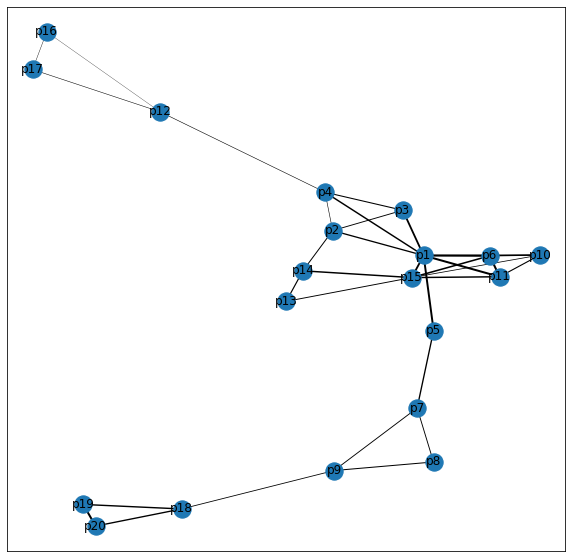

In [12]:
# visualization
durations = [x['weight'] for x in dict(p2p_norm_graph.edges).values()]
labels = [x for x in dict(p2p_norm_graph.nodes).keys()]
labels = {x:x for x in dict(p2p_norm_graph.nodes).keys()}

fig, ax = plt.subplots(figsize=(10,10))
pos = nx.spring_layout(p2p_norm_graph)
nx.draw_networkx_nodes(p2p_norm_graph, pos, ax = ax, label=True)
nx.draw_networkx_edges(p2p_norm_graph, pos, width=durations, ax=ax)
_ = nx.draw_networkx_labels(p2p_norm_graph, pos, labels, ax=ax)

## Analysis of Contact Tracing
- degree of nodes
    - most important person
    - most influential person
    - most connected person

In [13]:
# graph
p2p_graph = nx.from_pandas_edgelist(p2p_netw_data,'person','contact', edge_attr='weight')

In [14]:
# list the nodes and their analysis
def sort_network_degree(net_data):
    temp = []
    for w in sorted(net_data, key=net_data.get, reverse=True):
        # print(f'{w} :: {net_data[w]}')
        temp.append((w, net_data[w]))
    return temp

#### Most Influential Person
- no weights
- influential in terms of most connection nodes

In [15]:
# most influential
sort_network_degree(nx.degree_centrality(p2p_graph))

[('p1', 0.42105263157894735),
 ('p15', 0.3157894736842105),
 ('p2', 0.21052631578947367),
 ('p4', 0.21052631578947367),
 ('p6', 0.21052631578947367),
 ('p10', 0.21052631578947367),
 ('p11', 0.21052631578947367),
 ('p3', 0.15789473684210525),
 ('p14', 0.15789473684210525),
 ('p12', 0.15789473684210525),
 ('p7', 0.15789473684210525),
 ('p9', 0.15789473684210525),
 ('p18', 0.15789473684210525),
 ('p5', 0.10526315789473684),
 ('p8', 0.10526315789473684),
 ('p16', 0.10526315789473684),
 ('p17', 0.10526315789473684),
 ('p13', 0.10526315789473684),
 ('p19', 0.10526315789473684),
 ('p20', 0.10526315789473684)]

#### Most Connected Person (Wide Spreader)
- person who are more likely to spread to more people
- after p1 is p5, see list above. from the figure from network visualization we see that if p5 does not exist then p7, p8, p9, p18, p19, p20 will not be included in the list, additional total of 6 person in the contact network.

In [16]:
# most used bridge or connection
bridge_list = sort_network_degree(nx.betweenness_centrality(p2p_graph, weight='weight'))
bridge_list

[('p1', 0.5964912280701754),
 ('p5', 0.45614035087719296),
 ('p7', 0.4093567251461988),
 ('p4', 0.2807017543859649),
 ('p9', 0.2807017543859649),
 ('p12', 0.19883040935672514),
 ('p18', 0.19883040935672514),
 ('p2', 0.13450292397660818),
 ('p15', 0.08187134502923976),
 ('p14', 0.07017543859649122),
 ('p3', 0.0),
 ('p6', 0.0),
 ('p10', 0.0),
 ('p11', 0.0),
 ('p8', 0.0),
 ('p16', 0.0),
 ('p17', 0.0),
 ('p13', 0.0),
 ('p19', 0.0),
 ('p20', 0.0)]

#### Most Important Person (Infection Vulnerability)
- returns list of person's risk value in descending
- higher value = more vulnerable to covid
- this must be the metric to find who to test first

In [17]:
# most important connection
sort_network_degree(nx.eigenvector_centrality(p2p_graph, weight='weight'))

[('p1', 0.5712658816018152),
 ('p6', 0.4082942906679761),
 ('p11', 0.37933737922840527),
 ('p15', 0.3531865507533995),
 ('p10', 0.27222032229537124),
 ('p3', 0.22003758832219247),
 ('p4', 0.18642150072170463),
 ('p5', 0.18235711956774078),
 ('p2', 0.1807168677575178),
 ('p14', 0.10036070253081737),
 ('p13', 0.05877213823784436),
 ('p7', 0.036451084043660036),
 ('p12', 0.01440109182492027),
 ('p9', 0.005640238580654925),
 ('p8', 0.005577930676347361),
 ('p17', 0.001027320254544509),
 ('p18', 0.0006645172842694355),
 ('p16', 0.0006077832590213976),
 ('p19', 0.00016417489496713328),
 ('p20', 0.00016013071396296294)]

### Contact Testing Ordinality
- we use most important person as the metric
    - eigenvector centrality
- we need to remove the covid poisitive person in the list   

In [18]:
# remove the covid positive people
list_important = sort_network_degree(nx.eigenvector_centrality(p2p_graph, weight='weight'))

In [19]:
for_test = []
for i in list_important:
    # find the covid positive persons
    has_covid = person_data['confirmed_covid'].loc[person_data['person'] == i[0]]
    # list non covid positive
    if not has_covid.bool():
        for_test.append(i)
for_test

[('p15', 0.3531865507533995),
 ('p10', 0.27222032229537124),
 ('p3', 0.22003758832219247),
 ('p4', 0.18642150072170463),
 ('p2', 0.1807168677575178),
 ('p14', 0.10036070253081737),
 ('p13', 0.05877213823784436),
 ('p7', 0.036451084043660036),
 ('p12', 0.01440109182492027),
 ('p9', 0.005640238580654925),
 ('p8', 0.005577930676347361),
 ('p17', 0.001027320254544509),
 ('p18', 0.0006645172842694355),
 ('p16', 0.0006077832590213976),
 ('p19', 0.00016417489496713328),
 ('p20', 0.00016013071396296294)]

# Ranking the Persons

In [20]:
# build dataframe for ranking
ranking_data = pd.DataFrame(columns=['person', 'has_covid', 'vulnerable_rank', 'spreader_rank'])
ranking_data['person'] = person_data['person']
ranking_data['has_covid'] = person_data['confirmed_covid']
ranking_data['vulnerable_rank'] = 0
ranking_data['spreader_rank'] = 0
ranking_data

,person,has_covid,vulnerable_rank,spreader_rank
0,p1,True,0,0
1,p2,False,0,0
2,p3,False,0,0
3,p4,False,0,0
4,p5,True,0,0
5,p6,True,0,0
6,p7,False,0,0
7,p8,False,0,0
8,p9,False,0,0
9,p10,False,0,0


In [21]:
# ranker function
def rank_data(data):
    temp = []
    for i in range(len(data)):
        p, val = data[i]
        temp.append((p, i+1))
    return temp

In [22]:
# set ranking for spreader
rank_spread = rank_data(bridge_list)
rank_spread

[('p1', 1),
 ('p5', 2),
 ('p7', 3),
 ('p4', 4),
 ('p9', 5),
 ('p12', 6),
 ('p18', 7),
 ('p2', 8),
 ('p15', 9),
 ('p14', 10),
 ('p3', 11),
 ('p6', 12),
 ('p10', 13),
 ('p11', 14),
 ('p8', 15),
 ('p16', 16),
 ('p17', 17),
 ('p13', 18),
 ('p19', 19),
 ('p20', 20)]

In [23]:
# set ranking for vulnerable / for test
rank_test = rank_data(for_test)
rank_test

[('p15', 1),
 ('p10', 2),
 ('p3', 3),
 ('p4', 4),
 ('p2', 5),
 ('p14', 6),
 ('p13', 7),
 ('p7', 8),
 ('p12', 9),
 ('p9', 10),
 ('p8', 11),
 ('p17', 12),
 ('p18', 13),
 ('p16', 14),
 ('p19', 15),
 ('p20', 16)]

### set the dataframe of ranking

In [24]:
def populate_rank_data(data, rank_list, rank_class):
    for i in range(len(rank_list)):
        data[rank_class].loc[data['person'] == rank_list[i][0]] = rank_list[i][1]

In [25]:
populate_rank_data(ranking_data, rank_spread, 'spreader_rank')
populate_rank_data(ranking_data, rank_test, 'vulnerable_rank')

# CONCLUSION FOR COVID TESTING / CONTACT TESTING
- visualized contact network with weights
- testing ranking and spreader ranking
- vulnerability rank = eigenvector; spreader rank = betweenness centrality

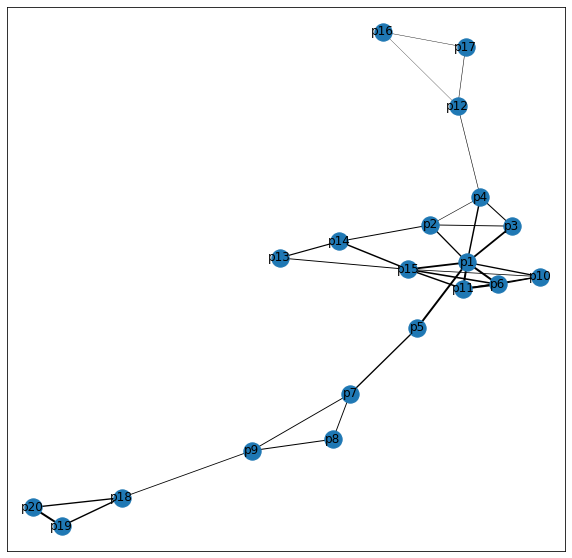

In [26]:
# visualization
durations = [x['weight'] for x in dict(p2p_norm_graph.edges).values()]
labels = [x for x in dict(p2p_norm_graph.nodes).keys()]
labels = {x:x for x in dict(p2p_norm_graph.nodes).keys()}

fig, ax = plt.subplots(figsize=(10,10))
pos = nx.spring_layout(p2p_norm_graph)
nx.draw_networkx_nodes(p2p_norm_graph, pos, ax = ax, label=True)
nx.draw_networkx_edges(p2p_norm_graph, pos, width=durations, ax=ax)
_ = nx.draw_networkx_labels(p2p_norm_graph, pos, labels, ax=ax)

In [27]:
# final ranking data
ranking_data.to_csv('data/ranked_person_contact.csv', index=False)
ranking_data

,person,has_covid,vulnerable_rank,spreader_rank
0,p1,True,0,1
1,p2,False,5,8
2,p3,False,3,11
3,p4,False,4,4
4,p5,True,0,2
5,p6,True,0,12
6,p7,False,8,3
7,p8,False,11,15
8,p9,False,10,5
9,p10,False,2,13


In [ ]:
#

### Discussion
- vulnerable rank
    - 0 are for those who are diagnosed with covid, not included in testing
    - we test 'person' in ascending order
- spreader rank
    - here, we still include those covid positive
    - spreader rank is in ascending order
- network visualization
    - thicker edge higher risk of infection / vulnerability between two contacts
    - p5 is set as 2nd rank spreader, we can see that p5 is the ancestor node of p7, p8, p9, p18, p20, p19 (6 nodes) meaning that if p5 does not exist then either the 8 others will be in the network